In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection, preprocessing
from sklearn import metrics
import xgboost as xgb

import pandas as pd
import numpy as np
from numpy import load

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib import offsetbox
%matplotlib inline

In [ ]:
#### chargement des données ####
np.load.__defaults__=(None, True, True, 'ASCII')

X_brain= load('/content/drive/My Drive/Colab_outputs/X_brain_256.npy')
y_brain = load('/content/drive/My Drive/Colab_outputs/y_brain.npy')

X_train_reduced = load('/content/drive/My Drive/Colab_outputs/X_train_reduced_256.npy')
y_train = load('/content/drive/My Drive/Colab_outputs/y_train_reduced_256.npy')
X_test_reduced = load('/content/drive/My Drive/Colab_outputs/X_test_reduced_256.npy')
y_test = load('/content/drive/My Drive/Colab_outputs/y_test_reduced_256.npy')

Afin de faire tourner les modèles de classification de machine learning pour ce type de données, il faut réaliser une transformation vectorielle au minimum. Mais aussi, vu le nombre de features qui sont représentées pour une donnée (65 536), et si l'on cherche les meilleurs hyperparamètres qui maximisent les performance de notre modèle, il faut s'attendre à des temps de traitement excessivement longs ! Le choix a donc été fait de prendre les données réduites (cf notebook sur la réduction des données) et de les appliquer à ces modèles.

In [ ]:
### on reshape X_brain pour avoir un 2D array (vecteur pour application sur modèle de Machine Learning) ###
'''
X_brain_rf = X_brain[...,0]
#ou means avec -1
X_brain_rf = X_brain_rf.reshape([-1,256*256])
X_brain_rf.shape

(2501, 65536)

Par cette transformation vectorielle, on a (normalement) une perte d'information importante.

In [ ]:
### split des données ###
'''
X_train, X_test, y_train, y_test = train_test_split(X_brain_rf, y_brain, test_size=0.2)

In [ ]:
print(X_train_reduced.shape)
print(y_train.shape)
print(X_test_reduced.shape)
print(y_test.shape)

(2000, 1)
(2000,)
(501, 1)
(501,)


In [ ]:
###########################
##      Modèle SVM       ##
###########################

params = {'C':[0.1,1,10], 
              'kernel': ['rbf', 'linear','poly'],
              'gamma':[1,0.1,0.01,0.001]}

grid = GridSearchCV(estimator=SVC(), param_grid=params, cv=5)
grid = grid.fit(X_train_reduced, y_train)
print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']]) 

                                            params  mean_test_score
0          {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}           0.9845
1       {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}           0.9850
2         {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}           0.9825
3        {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}           0.9850
4     {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}           0.9850
5       {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}           0.9815
6       {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}           0.9830
7    {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}           0.9850
8      {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}           0.9185
9      {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}           0.9635
10  {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}           0.9850
11    {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}           0.8720
12           {'C': 1, 'gamma': 1, 'kernel': 'rbf'}           0.9860
13        {'C': 1, 'gamma': 1, 'kernel': 'linear

In [ ]:
grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [ ]:
y_pred =grid.predict(X_test_reduced)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,423,16
1,16,46


In [ ]:
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score

print (classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.96      0.74      0.96      0.85      0.73       439
          1       0.74      0.74      0.96      0.74      0.85      0.70        62

avg / total       0.94      0.94      0.77      0.94      0.85      0.73       501



Le f1-score est une des métriques très utilisée pour juger de la performance d'un modèle quand il y a déséquilibre de classe, ce qui est le cas ici (p=318/2501). Le résultat est largement acceptable sur ce que renvoit ce type de modèle, sachant que l'on a une perte d'information dû à la vectorisation dans un premier temps et à la réduction des données dans un second, et donc de la vitesse de calcul de l'ensemble. pour rappel: https://train.datascientest.com/hub/johann_ambrugeat@yahoo.fr/notebooks/135/440

Le F1-score permet de mesurer la précision et le rappel à la fois. Une autre métrique, la moyenne géometrique (geometric mean), s'avère utile pour les problèmes de classification déséquilibrée : il s'agit de la racine du produit de la sensibilité et de la spécificité, qui est ici très acceptable également.

In [ ]:
###########################
##      Modèle KNN       ##
###########################

params = {'n_neighbors':[i for i in range(40)], 
              'metric': ['manhattan', 'minkowski','chebyshev']}

grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5)
grid = grid.fit(X_train_reduced, y_train)
print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_score']]) 

                                         params  mean_test_score
0     {'metric': 'manhattan', 'n_neighbors': 0}              NaN
1     {'metric': 'manhattan', 'n_neighbors': 1}           0.9780
2     {'metric': 'manhattan', 'n_neighbors': 2}           0.9755
3     {'metric': 'manhattan', 'n_neighbors': 3}           0.9830
4     {'metric': 'manhattan', 'n_neighbors': 4}           0.9815
..                                          ...              ...
115  {'metric': 'chebyshev', 'n_neighbors': 35}           0.9855
116  {'metric': 'chebyshev', 'n_neighbors': 36}           0.9845
117  {'metric': 'chebyshev', 'n_neighbors': 37}           0.9850
118  {'metric': 'chebyshev', 'n_neighbors': 38}           0.9850
119  {'metric': 'chebyshev', 'n_neighbors': 39}           0.9855

[120 rows x 2 columns]


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py", line 198, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_base.py", line 569, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
ValueError: Expec

In [ ]:
grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 24}

In [ ]:
y_pred =grid.predict(X_test_reduced)

pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,423,16
1,16,46


In [ ]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.96      0.74      0.96      0.85      0.73       439
          1       0.74      0.74      0.96      0.74      0.85      0.70        62

avg / total       0.94      0.94      0.77      0.94      0.85      0.73       501



Même remarque que précédemment, les scores sont identiques

In [ ]:
###########################
##      Random Forest    ##
###########################

clf = RandomForestClassifier(n_jobs=-1, random_state=321)
clf.fit(X_train_reduced, y_train)
y_pred = clf.predict(X_test_reduced)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,0,1
Classe réelle,,
0,416,23
1,19,43


In [ ]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.95      0.69      0.95      0.81      0.67       439
          1       0.65      0.69      0.95      0.67      0.81      0.64        62

avg / total       0.92      0.92      0.72      0.92      0.81      0.67       501



Les résultats sont un peu moins bons qu'avec les précédents modèles

In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


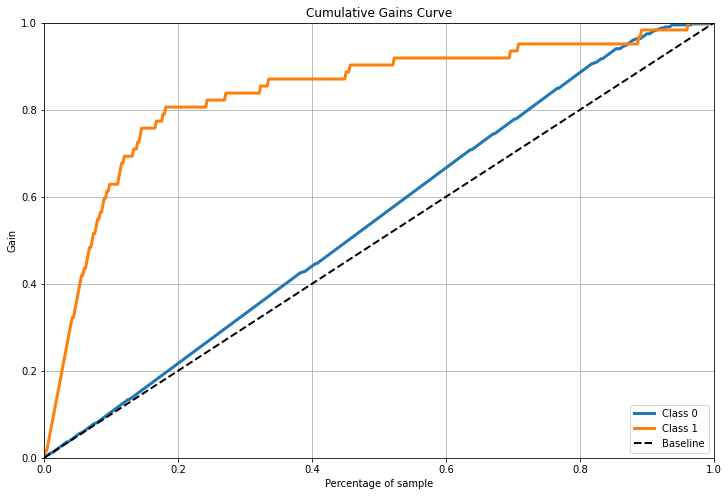

In [ ]:
import scikitplot as skplt

y_probas = clf.predict_proba(X_test_reduced)
skplt.metrics.plot_cumulative_gain(y_test, y_probas, figsize=(12,8))
plt.show()

Cela montre qu'avec 20% des images avec la plus forte proba de présenter une hémorragie, environ 90% des hémorragies 
peuvent être prédites. N'a pas trop de sens dans le cadre de cette étude